# SM05: ETL Pipeline

In order to explain how to write the `.py` script, I first had to explain how the pipeline steps work and pass information to/from the script. However, the `.py` script should be run before the pipeline definition. So here is the full code to get the pipeline up and running.

### Python Script : Pipe Step

Of note when writing the Python script and it's pipeline step:

- The input_path should match `destination` for `inputs` of the `ProcessingStep` definition
- The output_path should match `source` for `outputs` of the `ProcessingStep` definition

#### Example:


**Python Script**

```
if __name__ == '__main__':
    input_path = '/opt/ml/processing/input'
    output_path = '/opt/ml/processing/output'
```

**Pipeline Step**

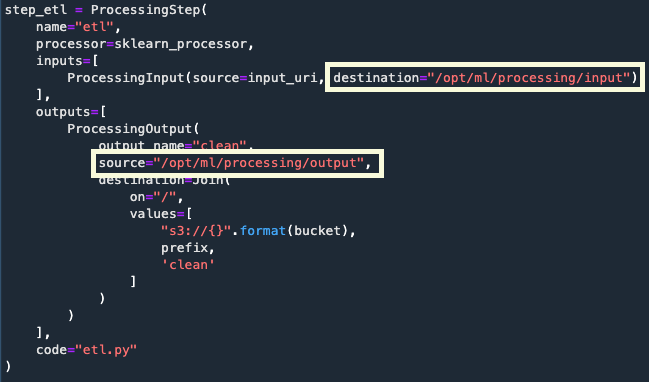

## Intermediate step - Load data

What I originally wanted to do was reference the webpages where the raw data is stored in the pipeline. However, it doesn't appear that SageMaker Pipelines aren't enabled to pull directly from the web. The easiest and most viable data storage I've found is S3. The below cell pulls the data from the UCI repo and loads it to S3. After running that cell, the pipeline can be run.

*Note*, I updated the folder name to `1_ins_dataset` because I got tired of scrolling through all the folders in my default bucket.

In [6]:
# Load data to S3
import pandas as pd
import sagemaker

session = sagemaker.session.Session()
bucket = session.default_bucket()
prefix = '1_ins_dataset/raw'

train_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/ticdata2000.txt'
test_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/ticeval2000.txt'
gt_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/tictgts2000.txt'
cols_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/dictionary.txt'

train = pd.read_table(train_uri, header=None)
test = pd.read_table(test_uri, header=None)
ground_truth = pd.read_table(gt_uri, header=None)
columns = pd.read_table(cols_uri, encoding='latin-1')

train.to_csv(f's3://{bucket}/{prefix}/train.csv', index=False)
test.to_csv(f's3://{bucket}/{prefix}/test.csv', index=False)
ground_truth.to_csv(f's3://{bucket}/{prefix}/gt.csv', index=False)
columns.to_csv(f's3://{bucket}/{prefix}/col_info.csv', index=False)

## Write Python script

In [14]:
%%writefile etl.py
import pandas as pd
import os

if __name__ == '__main__':
    input_path = '/opt/ml/processing/input'
    output_path = '/opt/ml/processing/output'
    
    col_names = ['zip_agg Customer Subtype',
            'zip_agg Number of houses',
            'zip_agg Avg size household',
            'zip_agg Avg age',
            'zip_agg Customer main type',
            'zip_agg Roman catholic',
            'zip_agg Protestant',
            'zip_agg Other religion',
            'zip_agg No religion',
            'zip_agg Married',
            'zip_agg Living together',
            'zip_agg Other relation',
            'zip_agg Singles',
            'zip_agg Household without children',
            'zip_agg Household with children',
            'zip_agg High level education',
            'zip_agg Medium level education',
            'zip_agg Lower level education',
            'zip_agg High status',
            'zip_agg Entrepreneur',
            'zip_agg Farmer',
            'zip_agg Middle management',
            'zip_agg Skilled labourers',
            'zip_agg Unskilled labourers',
            'zip_agg Social class A',
            'zip_agg Social class B1',
            'zip_agg Social class B2',
            'zip_agg Social class C',
            'zip_agg Social class D',
            'zip_agg Rented house',
            'zip_agg Home owners',
            'zip_agg 1 car',
            'zip_agg 2 cars',
            'zip_agg No car',
            'zip_agg National Health Service',
            'zip_agg Private health insurance',
            'zip_agg Income < 30.000',
            'zip_agg Income 30-45.000',
            'zip_agg Income 45-75.000',
            'zip_agg Income 75-122.000',
            'zip_agg Income >123.000',
            'zip_agg Average income',
            'zip_agg Purchasing power class',
            'Contri private third party ins',
            'Contri third party ins (firms)',
            'Contri third party ins (agriculture)',
            'Contri car policies',
            'Contri delivery van policies',
            'Contri motorcycle/scooter policies',
            'Contri lorry policies',
            'Contri trailer policies',
            'Contri tractor policies',
            'Contri agricultural machines policies',
            'Contri moped policies',
            'Contri life ins',
            'Contri private accident ins policies',
            'Contri family accidents ins policies',
            'Contri disability ins policies',
            'Contri fire policies',
            'Contri surfboard policies',
            'Contri boat policies',
            'Contri bicycle policies',
            'Contri property ins policies',
            'Contri ss ins policies',
            'Nbr private third party ins',
            'Nbr third party ins (firms)',
            'Nbr third party ins (agriculture)',
            'Nbr car policies',
            'Nbr delivery van policies',
            'Nbr motorcycle/scooter policies',
            'Nbr lorry policies',
            'Nbr trailer policies',
            'Nbr tractor policies',
            'Nbr agricultural machines policies',
            'Nbr moped policies',
            'Nbr life ins',
            'Nbr private accident ins policies',
            'Nbr family accidents ins policies',
            'Nbr disability ins policies',
            'Nbr fire policies',
            'Nbr surfboard policies',
            'Nbr boat policies',
            'Nbr bicycle policies',
            'Nbr property ins policies',
            'Nbr ss ins policies',
            'Nbr mobile home policies']

    train = pd.read_csv(os.path.join(input_path, 'train.csv'))
    test = pd.read_csv(os.path.join(input_path, 'test.csv'))
    ground_truth = pd.read_csv(os.path.join(input_path, 'gt.csv'))
    columns = pd.read_csv(os.path.join(input_path, 'col_info.csv'))

    data_dict = {}
    data_dict['feat_info'] = columns.iloc[1:87, 0].str.split(n=2, expand=True)
    data_dict['feat_info'].columns = columns.iloc[0, 0].split(maxsplit=2)
    data_dict['L0'] = columns.iloc[89:130, 0].str.split(n=1, expand=True)
    data_dict['L0'].columns = columns.iloc[88, 0].split()
    data_dict['L2'] = columns.iloc[138:148, 0].str.split(n=1, expand=True)
    data_dict['L2'].columns = ['Value', 'Bin']

    test_df = pd.concat([test, ground_truth], axis=1)
    test_df.columns = data_dict['feat_info']['Name'].to_list()
    train.columns = data_dict['feat_info']['Name'].to_list()

    df = pd.concat([train, test_df], ignore_index=True)
    df.columns = col_names

    data_dict['L0']['Value'] = pd.to_numeric(data_dict['L0']['Value'])
    l0_dict = data_dict['L0'].set_index('Value').to_dict()['Label']
    data_dict['L2']['Value'] = pd.to_numeric(data_dict['L2']['Value'])
    l2_dict = data_dict['L2'].set_index('Value').to_dict()['Bin']
    df[df.columns[0]] = df[df.columns[0]].replace(l0_dict)
    df[df.columns[4]] = df[df.columns[4]].replace(l2_dict)

    df.to_csv(os.path.join(output_path, 'full_data.csv'), index=False)

Overwriting etl.py


## Define SageMaker Pipeline

In [ ]:
import sagemaker
import sagemaker.session

from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString)

from sagemaker.workflow.functions import Join
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.pipeline import Pipeline

session = sagemaker.session.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()

bucket = session.default_bucket()
prefix = '1_ins_dataset'
pipeline_name = "InsExample"  # SageMaker Pipeline name
model_package_group_name = "Insurance Co Example"  # Model name in model registry
framework_version = "0.23-1"

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.t3.medium")

input_uri = Join(on="/", values=['s3://{}'.format(bucket),
                                      prefix,
                                      'raw'])

tags = [
    {"Key": "DATASET", "Value": "InsCOIL"},
    {"Key": "SOURCE", "Value": "UCI"}
   ]

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="ins-example-job"
)

step_etl = ProcessingStep(
    name="etl",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_uri, destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(
            output_name="clean",
            source="/opt/ml/processing/output",
            destination=Join(
                on="/",
                values=[
                    "s3://{}".format(bucket),
                    prefix,
                    'clean'
                ]
            )
        )
    ],
    code="etl.py"
)

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count
    ],
    steps=[step_etl])

pipeline.upsert(role_arn=role, tags=tags)

pipeline.start(
    execution_display_name="InsClean")

## Delete Files

*Don't run the below cells until you're done with the data!*

To ensure no ongoing charges are charged to your account, you can delete the files from S3.

In [19]:
dir_loc = '1_ins_dataset/'

In [ ]:
s3_bucket = s3_resource.Bucket(bucket)
s3_bucket.objects.filter(Prefix=dir_loc).delete()